 MULTICLASS SVM ON VAE LATENT SPACE (FAULT TYPE CLASSIFIER)
Using latent dir: C:\Users\ahasa\project_root\data\eclss_preprocessed

Loaded faulty latent splits:
  Z_train_fault: (420, 32)
  Z_test_fault:  (180, 32)
  y_train_fault_sys: (420,)
  y_test_fault_sys:  (180,)

Feature scaling done (StandardScaler).

Training SVM (RBF kernel) with small grid search over C and gamma...
Best SVM params: {'C': 100.0, 'gamma': 0.1}
Best CV accuracy: 0.9548

 BIAS–VARIANCE ANALYSIS (CV vs TRAIN ACCURACY)
Training Accuracy: 0.9952
Cross-Validation Accuracy: 0.9548
Generalization Gap (Train − CV): 0.0405



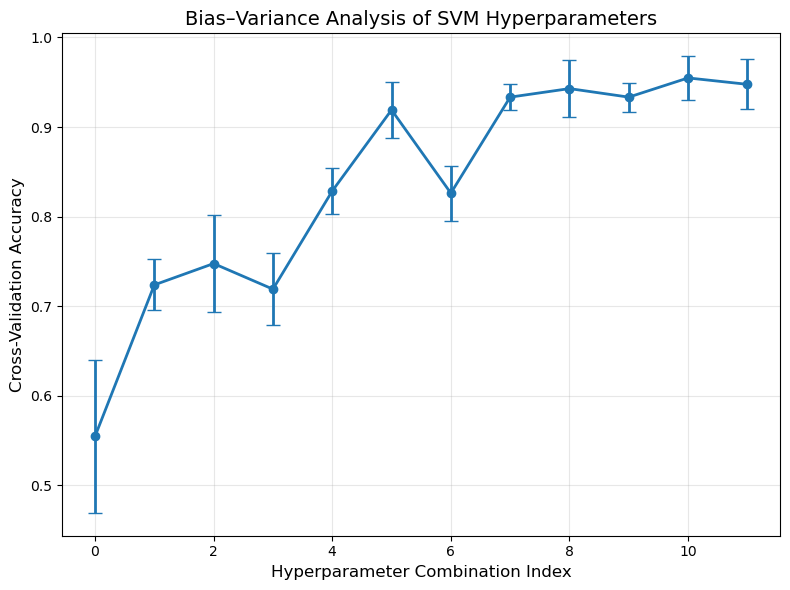

 TRAIN PERFORMANCE ON FAULTY SAMPLES (FAULT-TYPE CLASSIFIER)
Train Accuracy: 0.9952

Train Confusion Matrix:
[[84  0  0  0  0]
 [ 0 83  1  0  0]
 [ 0  1 83  0  0]
 [ 0  0  0 84  0]
 [ 0  0  0  0 84]]

Train Classification Report:
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000        84
           2     0.9881    0.9881    0.9881        84
           3     0.9881    0.9881    0.9881        84
           4     1.0000    1.0000    1.0000        84
           5     1.0000    1.0000    1.0000        84

    accuracy                         0.9952       420
   macro avg     0.9952    0.9952    0.9952       420
weighted avg     0.9952    0.9952    0.9952       420


Generating learning curves...


<Figure size 640x480 with 0 Axes>

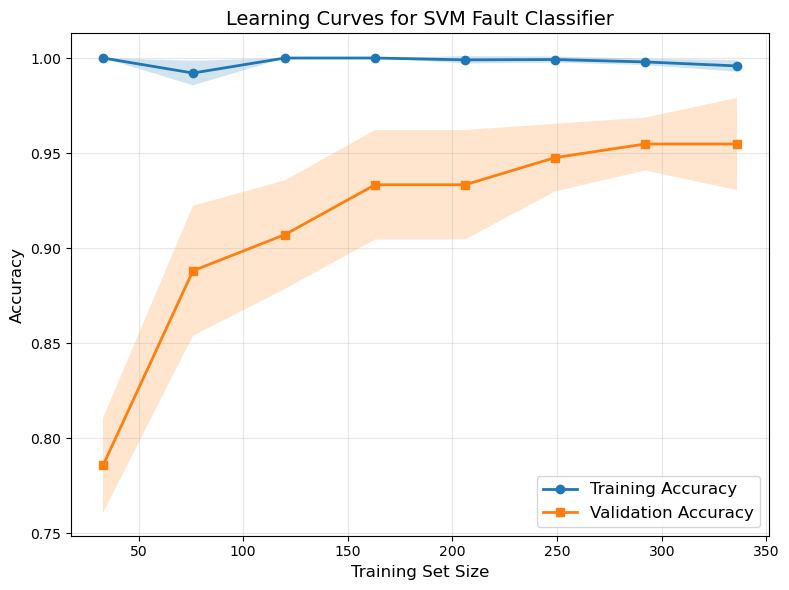

 TEST PERFORMANCE ON FAULTY SAMPLES (FAULT-TYPE CLASSIFIER)
Accuracy (fault-type classification, faults only): 0.9556

Confusion matrix (rows = true, cols = predicted):
[[36  0  0  0  0]
 [ 1 34  1  0  0]
 [ 0  3 32  1  0]
 [ 2  0  0 34  0]
 [ 0  0  0  0 36]]

Classification report (per fault type):
              precision    recall  f1-score   support

           1     0.9231    1.0000    0.9600        36
           2     0.9189    0.9444    0.9315        36
           3     0.9697    0.8889    0.9275        36
           4     0.9714    0.9444    0.9577        36
           5     1.0000    1.0000    1.0000        36

    accuracy                         0.9556       180
   macro avg     0.9566    0.9556    0.9554       180
weighted avg     0.9566    0.9556    0.9554       180

 SAVED MODELS
  SVM model : C:\Users\ahasa\project_root\models\svm_fault_classifier.pkl
  Scaler    : C:\Users\ahasa\project_root\models\svm_fault_scaler.pkl
You can later load these for prediction or downstrea

<Figure size 640x480 with 0 Axes>

In [2]:
"""
train_svm_fault_classifier.py

Train a multiclass SVM on the VAE latent space to classify
ECLSS fault *types* (system-level labels).

Pipeline:
  1) Load latent features (from encode_latent_splits.py) and labels:
        - Z_train_fault.npy   (350, latent_dim)
        - Z_test_fault.npy    (150, latent_dim)
        - y_train_fault_sys.npy
        - y_test_fault_sys.npy

     Here, y_*_fault_sys contains class IDs for fault types
     (e.g., 1 = CO2 leak, 2 = O2 valve, ...).

  2) Standardize features using StandardScaler (fit on train).
  3) Train an RBF SVM (C, gamma chosen via a small grid search).
  4) Evaluate on the *faulty* test set:
        - Overall accuracy
        - Confusion matrix
        - Per-class precision/recall/F1
  5) Save the trained SVM model to models/svm_fault_classifier.pkl
"""

from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Tuple

import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
)
from sklearn.model_selection import GridSearchCV
import joblib


# ============================================================
# PATHS & CONFIG
# ============================================================

REPO_ROOT = Path(r"C:\Users\ahasa\project_root")
DATA_ROOT = REPO_ROOT / "data"
PRE_DIR = DATA_ROOT / "eclss_preprocessed"
MODEL_DIR = REPO_ROOT / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)


@dataclass
class SVMConfig:
    random_state: int = 7
    # A small grid for C and gamma; we can expand later if needed
    C_grid: Tuple[float, ...] = (0.1, 1.0, 10.0, 100.0)
    gamma_grid: Tuple[float, ...] = (0.01, 0.1, 1.0)


cfg = SVMConfig()


# ============================================================
# MAIN
# ============================================================

def main() -> None:
    print("============================================================")
    print(" MULTICLASS SVM ON VAE LATENT SPACE (FAULT TYPE CLASSIFIER)")
    print("============================================================")
    print(f"Using latent dir: {PRE_DIR}")
    print()

    # --------------------------------------------------------
    # 1) LOAD LATENT FEATURES & LABELS
    # --------------------------------------------------------
    Z_train_fault = np.load(PRE_DIR / "Z_train_fault.npy")   # (350, latent_dim)
    Z_test_fault = np.load(PRE_DIR / "Z_test_fault.npy")     # (150, latent_dim)

    y_train_fault_sys = np.load(PRE_DIR / "y_train_fault_sys.npy")
    y_test_fault_sys = np.load(PRE_DIR / "y_test_fault_sys.npy")

    print("Loaded faulty latent splits:")
    print(f"  Z_train_fault: {Z_train_fault.shape}")
    print(f"  Z_test_fault:  {Z_test_fault.shape}")
    print(f"  y_train_fault_sys: {y_train_fault_sys.shape}")
    print(f"  y_test_fault_sys:  {y_test_fault_sys.shape}")
    print()

    # --------------------------------------------------------
    # 2) STANDARDIZE FEATURES
    # --------------------------------------------------------
    scaler = StandardScaler()
    Z_train_fault_scaled = scaler.fit_transform(Z_train_fault)
    Z_test_fault_scaled = scaler.transform(Z_test_fault)

    print("Feature scaling done (StandardScaler).")
    print()

    # --------------------------------------------------------
    # 3) TRAIN RBF SVM WITH SMALL GRID SEARCH
    # --------------------------------------------------------
    print("Training SVM (RBF kernel) with small grid search over C and gamma...")

    base_svm = SVC(
        kernel="rbf",
        probability=True,
        random_state=cfg.random_state,
    )

    param_grid = {
        "C": cfg.C_grid,
        "gamma": cfg.gamma_grid,
    }

    grid = GridSearchCV(
        estimator=base_svm,
        param_grid=param_grid,
        scoring="accuracy",
        cv=5,
        n_jobs=-1,
    )

    grid.fit(Z_train_fault_scaled, y_train_fault_sys)

    print(f"Best SVM params: {grid.best_params_}")
    print(f"Best CV accuracy: {grid.best_score_:.4f}")
    print()

    best_svm = grid.best_estimator_
# ============================================================
# 6) BIAS–VARIANCE ANALYSIS
# ============================================================
    print("============================================================")
    print(" BIAS–VARIANCE ANALYSIS (CV vs TRAIN ACCURACY)")
    print("============================================================")
    cv_results = grid.cv_results_
    mean_cv_scores = cv_results['mean_test_score']
    std_cv_scores = cv_results['std_test_score']

    train_acc = accuracy_score(
        y_train_fault_sys,
        best_svm.predict(Z_train_fault_scaled)
    )
    cv_acc = grid.best_score_

    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Cross-Validation Accuracy: {cv_acc:.4f}")
    print(f"Generalization Gap (Train − CV): {train_acc - cv_acc:.4f}\n")

# Plot CV scores for each hyperparameter combination
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8,6))
    plt.errorbar(
       range(len(mean_cv_scores)),
       mean_cv_scores,
       yerr=std_cv_scores,
       fmt='o-',
       capsize=5,
       linewidth=2
  )
    plt.title("Bias–Variance Analysis of SVM Hyperparameters", fontsize=14)
    plt.xlabel("Hyperparameter Combination Index", fontsize=12)
    plt.ylabel("Cross-Validation Accuracy", fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
# SAVE THE PLOT  🔽🔽🔽
    plt.savefig(MODEL_DIR / "svm_bias_variance_curve.png", dpi=300, bbox_inches="tight")

    # --------------------------------------------------------
# 3.5) EVALUATE ON FAULTY TRAIN SET (Training Accuracy)
# --------------------------------------------------------
    y_pred_train = best_svm.predict(Z_train_fault_scaled)

    train_acc = accuracy_score(y_train_fault_sys, y_pred_train)
    train_cm  = confusion_matrix(y_train_fault_sys, y_pred_train)

    print("============================================================")
    print(" TRAIN PERFORMANCE ON FAULTY SAMPLES (FAULT-TYPE CLASSIFIER)")
    print("============================================================")
    print(f"Train Accuracy: {train_acc:.4f}")
    print("\nTrain Confusion Matrix:")
    print(train_cm)
    print("\nTrain Classification Report:")
    print(
        classification_report(
           y_train_fault_sys,
           y_pred_train,
           digits=4,
       )
    )
    print()
    # ============================================================
# 7) LEARNING CURVES (TRAIN vs VALIDATION)
# ============================================================
    from sklearn.model_selection import learning_curve

    print("Generating learning curves...")

    train_sizes, train_scores, val_scores = learning_curve(
        best_svm,
        Z_train_fault_scaled,
        y_train_fault_sys,
        cv=5,
        train_sizes=np.linspace(0.1, 1.0, 8),
        scoring='accuracy',
        n_jobs=-1
        )

    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)

# Plot
    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy', linewidth=2)
    plt.plot(train_sizes, val_mean, 's-', label='Validation Accuracy', linewidth=2)

    plt.fill_between(train_sizes, 
                 train_mean - train_std, 
                 train_mean + train_std, 
                 alpha=0.2)
    plt.fill_between(train_sizes, 
                 val_mean - val_std, 
                 val_mean + val_std, 
                 alpha=0.2)

    plt.title("Learning Curves for SVM Fault Classifier", fontsize=14)
    plt.xlabel("Training Set Size", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
# SAVE LEARNING CURVE  🔽
    plt.savefig(MODEL_DIR / "Learning Curves for SVM Fault Classifier.png", dpi=300, bbox_inches="tight")

    # --------------------------------------------------------
    # 4) EVALUATE ON FAULTY TEST SET
    # --------------------------------------------------------
    y_pred_fault = best_svm.predict(Z_test_fault_scaled)

    acc = accuracy_score(y_test_fault_sys, y_pred_fault)
    cm = confusion_matrix(y_test_fault_sys, y_pred_fault)

    print("============================================================")
    print(" TEST PERFORMANCE ON FAULTY SAMPLES (FAULT-TYPE CLASSIFIER)")
    print("============================================================")
    print(f"Accuracy (fault-type classification, faults only): {acc:.4f}")
    print("\nConfusion matrix (rows = true, cols = predicted):")
    print(cm)
    print("\nClassification report (per fault type):")
    print(
        classification_report(
            y_test_fault_sys,
            y_pred_fault,
            digits=4,
        )
    )

    # --------------------------------------------------------
    # 5) SAVE MODEL & SCALER
    # --------------------------------------------------------
    svm_path = MODEL_DIR / "svm_fault_classifier.pkl"
    scaler_path = MODEL_DIR / "svm_fault_scaler.pkl"

    joblib.dump(best_svm, svm_path)
    joblib.dump(scaler, scaler_path)

    print("============================================================")
    print(" SAVED MODELS")
    print("============================================================")
    print(f"  SVM model : {svm_path.resolve()}")
    print(f"  Scaler    : {scaler_path.resolve()}")
    print("You can later load these for prediction or downstream analysis.")
    print()


if __name__ == "__main__":
    main()
